<a href="https://colab.research.google.com/github/vsnupoudel/RandomAssignments/blob/main/LB_Clustering_Silhoeu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA, Cleaning and Clustering for Forex Clients data

Credentials
- host: technical-test-1.cgajoruzs0oh.ap-southeast-2.rds.amazonaws.com
- port: 5432
- database: technical_test
- user: candidate
- password: NW337AkNQH76veGc

- **Install and restart kernel if needed**

In [65]:
# !pip install psycopg2
# !pip install yellowbrick

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2

In [67]:
class Connection:
    def __init__(self):
        self.connection = psycopg2.connect(user = "candidate",
                              password = "NW337AkNQH76veGc",
                              host = "technical-test-1.cgajoruzs0oh.ap-southeast-2.rds.amazonaws.com",
                              port = "5432",
                              database = "technical_test")
        
    def queryin(self, query_string):
        with self.connection.cursor()  as cursor: 
            cursor.execute( query_string )
            colnames = [desc[0] for desc in cursor.description]
            result_df = pd.DataFrame(cursor.fetchall(), columns=colnames)
            cursor.close()
        return result_df
    
    def close_conn(self):
        self.connection.close()        

## Tables are small enough to load directly into pd dataframe
- Reading Individual tables as dataframes and merging them in pandas.
- Could be joined directly later,if the table characteristics are known

In [68]:
connection = Connection()

In [69]:
select_table_query = '''SELECT column_name, data_type, is_nullable
FROM information_schema.columns
WHERE table_name in ('trades','users') ; '''

connection.queryin(select_table_query)

,column_name,data_type,is_nullable
0,login_hash,text,YES
1,ticket_hash,text,YES
2,server_hash,text,YES
3,symbol,text,YES
4,digits,bigint,YES
5,cmd,bigint,YES
6,volume,bigint,YES
7,open_time,timestamp without time zone,YES
8,open_price,double precision,YES
9,close_time,timestamp without time zone,YES


## From looking at tables
-duplicates in user table

In [70]:
print(connection.queryin('SELECT count(*) from users ;'))
print(connection.queryin('''select count(*) from (select DISTINCT login_hash,  country_hash, currency, enable 
from users) as sq;'''))

   count
0   1000
   count
0    666


- primary key of trades could be login_hash and ticket_hash

In [71]:
print( connection.queryin('''select count(*) from (select DISTINCT login_hash, ticket_hash from trades ) as sq;'''))
print( connection.queryin('''select count(*) from trades;''') )

    count
0  100000
    count
0  100000


## Observations
- trades is unique on login_hash and ticket_hash

### Storing users table as dataframe, and running checks on it

In [72]:
usersdf = connection.queryin('''select DISTINCT login_hash, server_hash, country_hash, currency, enable 
from users;''')

In [73]:
usersdf[usersdf['currency'] != 'USD'].sample(3)

,login_hash,server_hash,country_hash,currency,enable
513,FAE10F63521309082E08AF7849D3A880,3D1F7E00251C43107EF39F55300781DB,4442E4AF0916F53A07FB8CA9A49B98ED,AUD,1
255,276CB91E08BAACD855A954DFE0E76746,3D1F7E00251C43107EF39F55300781DB,4442E4AF0916F53A07FB8CA9A49B98ED,AUD,1
639,452E3BC11C4F036DF93E93EE4109D930,3D1F7E00251C43107EF39F55300781DB,4442E4AF0916F53A07FB8CA9A49B98ED,AUD,1


In [74]:
print(usersdf.shape)
print( len(usersdf.login_hash.unique() ) )

(666, 5)
666


- Now the table is unique on login_hash; So, can be joined with the trades table

# Check for null values before joining

In [75]:
usersdf.isna().sum()

login_hash      0
server_hash     0
country_hash    0
currency        0
enable          0
dtype: int64

In [76]:
tradesdf = connection.queryin('''SELECT * FROM trades;''')

In [77]:
print( len(tradesdf.login_hash.unique()) )
print( len(usersdf.login_hash.unique()))

5142
666


In [78]:
tradesdf.sample(2)

,login_hash,ticket_hash,server_hash,symbol,digits,cmd,volume,open_time,open_price,close_time,contractsize
81427,2369EEC226F9702B25C9EA254443510F,E40898FFA8AAE5238E583C3471522D7D,2F1CA40D76D7E6165DBA3924CE0D3B5C,USDCHF,5,0,10,2020-08-07 16:20:04,0.91550,2020-08-11 12:08:19,100000.0
82815,7060E30AD6D73F360B2D779416EE289C,014D2156BC6A6BA299F5F794FCBF1C93,2F1CA40D76D7E6165DBA3924CE0D3B5C,EURUSD,5,0,2,2020-08-13 17:11:00,1.18625,2020-08-14 09:07:01,100000.0


# Extract data and close connection
- left join on the fact table ( trades)

In [79]:
output = connection.queryin('''SELECT tr.*, usr.*
                                FROM trades as tr 
                                LEFT JOIN ( select DISTINCT login_hash,  country_hash, currency, enable 
                                from users)  as usr 
                                ON tr.login_hash = usr.login_hash;''')

connection.close_conn()

In [80]:
opath = 'outputdf.pkl'
output.to_pickle(path= opath )

# Read pickle file
- Doing operations one after another for clarity, can be chained later

In [81]:
opath = 'outputdf.pkl'
output = pd.read_pickle(opath)

In [82]:
output.head(3)

,login_hash,ticket_hash,server_hash,symbol,digits,cmd,volume,open_time,open_price,close_time,contractsize,login_hash,country_hash,currency,enable
0,58147CEE6BFB8404D6A78B1AF504DF3B,ACA5E99A3D0756083E96247BDC158E47,3D1F7E00251C43107EF39F55300781DB,GBPCAD,5,1,1,2020-08-14 05:55:22,1.72662,2020-08-14 08:02:13,100000.0,58147CEE6BFB8404D6A78B1AF504DF3B,4442E4AF0916F53A07FB8CA9A49B98ED,USD,1.0
1,58147CEE6BFB8404D6A78B1AF504DF3B,D3DCFA225F910CDF253E83EEBDD34928,3D1F7E00251C43107EF39F55300781DB,GBPCAD,5,1,1,2020-08-13 18:29:38,1.72811,2020-08-13 19:52:15,100000.0,58147CEE6BFB8404D6A78B1AF504DF3B,4442E4AF0916F53A07FB8CA9A49B98ED,USD,1.0
2,58147CEE6BFB8404D6A78B1AF504DF3B,E3D37B05AA4C234FAF17BB277B7CB0F0,3D1F7E00251C43107EF39F55300781DB,NZDJPY,3,0,2,2020-08-19 06:38:54,69.72500,2020-08-19 08:16:19,100000.0,58147CEE6BFB8404D6A78B1AF504DF3B,4442E4AF0916F53A07FB8CA9A49B98ED,USD,1.0


In [83]:
output.isnull().sum()

login_hash          0
ticket_hash         0
server_hash         0
symbol              0
digits              0
cmd                 0
volume              0
open_time           0
open_price          0
close_time          0
contractsize        7
login_hash      91953
country_hash    91953
currency        91953
enable          91953
dtype: int64

**Users table is not very useful as the login_hash joined with only 8% of the trades.**

In [84]:
output.dtypes

login_hash              object
ticket_hash             object
server_hash             object
symbol                  object
digits                   int64
cmd                      int64
volume                   int64
open_time       datetime64[ns]
open_price             float64
close_time      datetime64[ns]
contractsize           float64
login_hash              object
country_hash            object
currency                object
enable                 float64
dtype: object

In [85]:
output[ output.contractsize.isnull() ]

,login_hash,ticket_hash,server_hash,symbol,digits,cmd,volume,open_time,open_price,close_time,contractsize,login_hash,country_hash,currency,enable
1983,D33487486545A737682F7D1E5ECEABD8,EFC383645A70715146570CF4B4AF2607,2F1CA40D76D7E6165DBA3924CE0D3B5C,COFFEE,2,1,100,2020-08-31 18:32:06,127.67,2020-08-31 19:26:24,NaN,None,None,None,NaN
21147,32DE9EECD10691C33D28F716CC255364,7EB45147326758A1128032D6D67E2235,3D1F7E00251C43107EF39F55300781DB,COFFEE,2,0,100,2020-08-11 16:33:22,112.89,2020-08-12 16:51:29,NaN,None,None,None,NaN
71966,87664AA1F50A83BB2429989AA470A167,DDBAA964028BEBBDFF5EC91F9C268829,3D1F7E00251C43107EF39F55300781DB,COFFEE,2,0,100,2020-08-03 13:43:47,118.95,2020-08-05 16:18:59,NaN,None,None,None,NaN
92551,2BCA9F6675B4F907E51DE5570E443D2B,EE9AA9FD12760CDD3F86FE72F84CFD0A,2F1CA40D76D7E6165DBA3924CE0D3B5C,COFFEE,2,1,100,2020-08-17 12:10:50,115.55,2020-08-17 14:54:03,NaN,None,None,None,NaN
92552,2BCA9F6675B4F907E51DE5570E443D2B,87E404EF518982E7B276442506AFF3B4,2F1CA40D76D7E6165DBA3924CE0D3B5C,COFFEE,2,1,100,2020-08-19 13:59:06,121.68,2020-08-19 15:13:10,NaN,None,None,None,NaN
92559,2BCA9F6675B4F907E51DE5570E443D2B,3A4199B38A115C61789D3611B1490381,2F1CA40D76D7E6165DBA3924CE0D3B5C,COFFEE,2,0,100,2020-08-14 17:04:35,118.54,2020-08-14 19:51:32,NaN,None,None,None,NaN
92560,2BCA9F6675B4F907E51DE5570E443D2B,B883EA07D74C0EB619A7ECC92F59312C,2F1CA40D76D7E6165DBA3924CE0D3B5C,COFFEE,2,1,100,2020-08-19 15:46:03,121.37,2020-08-19 16:26:32,NaN,None,None,None,NaN


## Removing the users table joined as it is not useful

In [86]:
output.drop(columns=['country_hash','currency','enable'], axis=1, inplace=True)

In [87]:
df = output.iloc[:, :-1] #removing the duplicate column login_hash from users table part
# Do not run this twice, should be made reproducible

In [88]:
df.head(2)

,login_hash,ticket_hash,server_hash,symbol,digits,cmd,volume,open_time,open_price,close_time,contractsize
0,58147CEE6BFB8404D6A78B1AF504DF3B,ACA5E99A3D0756083E96247BDC158E47,3D1F7E00251C43107EF39F55300781DB,GBPCAD,5,1,1,2020-08-14 05:55:22,1.72662,2020-08-14 08:02:13,100000.0
1,58147CEE6BFB8404D6A78B1AF504DF3B,D3DCFA225F910CDF253E83EEBDD34928,3D1F7E00251C43107EF39F55300781DB,GBPCAD,5,1,1,2020-08-13 18:29:38,1.72811,2020-08-13 19:52:15,100000.0


In [89]:
# output[ output.login_hash == '2BCA9F6675B4F907E51DE5570E443D2B']

## Observation
1. The user table does not have all the users data. About 8% of the login_hash IDs match. Not very useful, so won't bother clustering on country, currency etc. In fact the users table is not that useful at all.
2. Imputing Contractsize (using KNN imputer or others) might not be a good idea, as it is not dependant on any other variable. Will remove these rows entirely.

In [90]:
df.shape

(100000, 11)

In [91]:
df = df[~df.contractsize.isna()]

In [92]:
df.shape

(99993, 11)

# Goal
You are also required to produce a simple K-Means clustering of the users. Assign each user to a single
cluster. Describe your choice for K and your logic for any pre-processing you have done. Please include
a performance evaluation. Present a frequency histogram for how many users are assigned to each cluster.
Please also provide a 3-D interactive graph using three principal components for the axis and the cluster
for the data point colour.


Your EDA should demonstrate your skill set, it should highlight novel findings about the data
and it will show your ability to analyse and tell stories with data. Please pay attention to
code quality and make sure you identify any issues with the data. 

## More EDA in pandas

In [93]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
digits,99993.0,3.214335,1.463187,0.00000,2.00000,2.00,5.00,5.0
cmd,99993.0,0.448161,0.497308,0.00000,0.00000,0.00,1.00,1.0
volume,99993.0,17.980909,100.439958,0.00000,1.00000,3.00,10.00,10000.0
open_price,99993.0,1262.624992,2585.183078,0.59167,1.19093,1887.73,1967.16,28795.0
contractsize,99993.0,44856.840239,49669.111281,1.00000,100.00000,100.00,100000.00,100000.0


In [94]:
df.describe(include= np.object).transpose()

,count,unique,top,freq
login_hash,99993,5142,18D4C2E739573770F9DF198F0E51C1B9,1223
ticket_hash,99993,99993,C5F5A8E938AADB4781DF66BB50BEAE38,1
server_hash,99993,3,2F1CA40D76D7E6165DBA3924CE0D3B5C,81059
symbol,99993,70,XAUUSD,49165


## Reset the data type to save memory

In [95]:
dtype_given = {'server_hash': 'category',
 'symbol': 'category',
 'contractsize':  'int64',
 'volume': 'int64',
  'cmd': 'bool',
'digits': 'int64'
              }
df = df.astype(dtype_given)

## K Means

In [96]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [97]:
df.head(2)

,login_hash,ticket_hash,server_hash,symbol,digits,cmd,volume,open_time,open_price,close_time,contractsize
0,58147CEE6BFB8404D6A78B1AF504DF3B,ACA5E99A3D0756083E96247BDC158E47,3D1F7E00251C43107EF39F55300781DB,GBPCAD,5,True,1,2020-08-14 05:55:22,1.72662,2020-08-14 08:02:13,100000
1,58147CEE6BFB8404D6A78B1AF504DF3B,D3DCFA225F910CDF253E83EEBDD34928,3D1F7E00251C43107EF39F55300781DB,GBPCAD,5,True,1,2020-08-13 18:29:38,1.72811,2020-08-13 19:52:15,100000


In [98]:
df['interval_hour'] = (df.close_time - df.open_time).dt.seconds / 3600

In [99]:
valid_columns = ['symbol','digits', 'cmd','volume', 'open_price','contractsize','interval_hour','server_hash']
categ_columns = ['symbol','server_hash']
df = df[valid_columns]

## ScatterPlot and Histograms

<string>:6: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.

<string>:6: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.



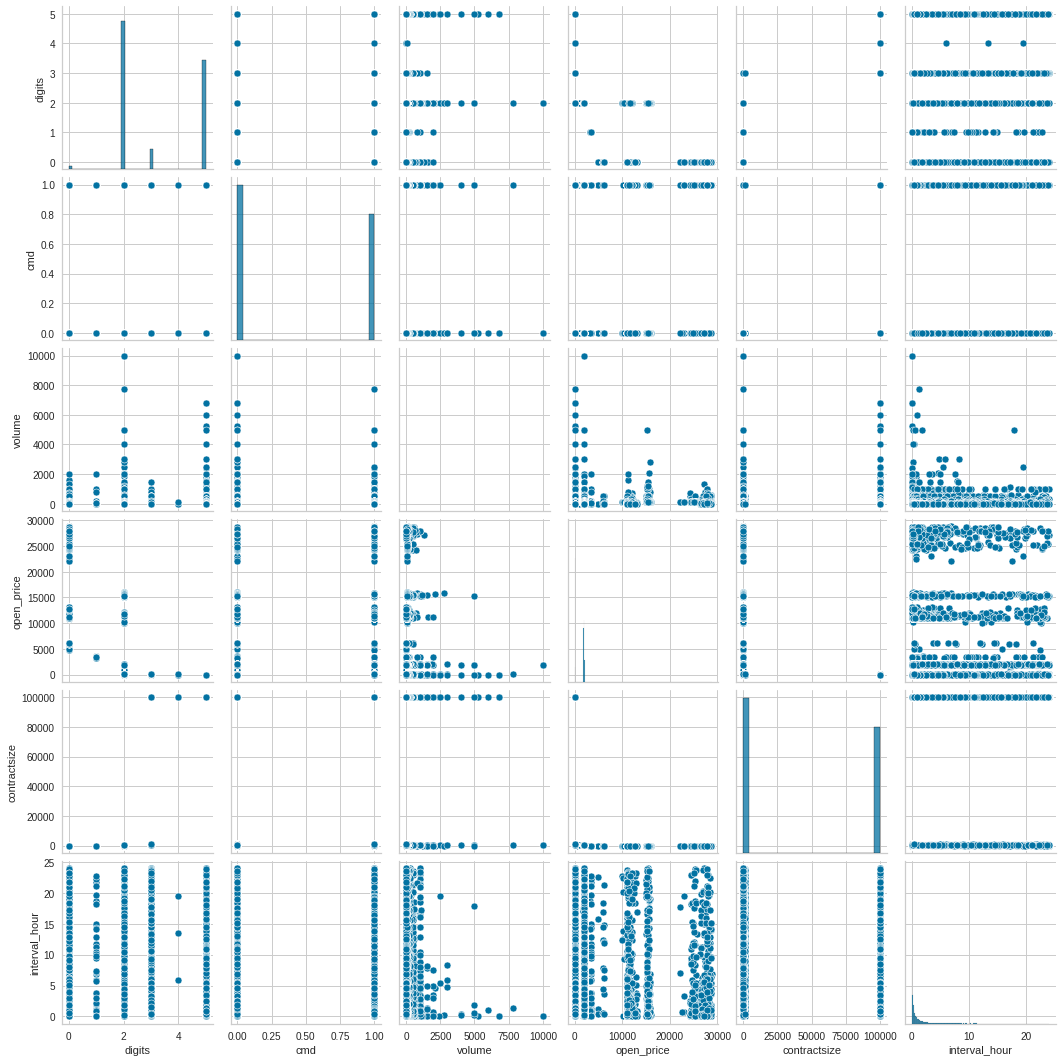

In [100]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (8,8)
sns.pairplot(data=df)

## Observation:
- Features not highly correlated
- They  look independant also

In [101]:
import copy
df_woh = copy.deepcopy(df)
df = pd.get_dummies(df, prefix='FromTo', prefix_sep='_', dummy_na=True, columns=categ_columns  )

## K means logic
- Will not use login_hash and ticket_hash as they are unique identifiers and won't help cluster similar points.
- Open time and close time are dates, which will not be very important as investment does not have a season generally.
- The interval between the open and close time will be considered ( in hours)
- Will run with value of k between 2 to 8, and then use silhouette method to choose K.

In [102]:
pipeline = Pipeline([('scaler', StandardScaler()), ('svc', KMeans())]) # create a pipeline
scaled = StandardScaler().fit_transform(df)  # Get just the scaled version of variables

In [103]:
kmfit = pipeline.fit_predict( df)  # fit the pipeline
np.unique(kmfit, return_counts=True) # count records in each cluster

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32),
 array([54638,   567, 38545,   877,  1989,   474,  1100,  1803]))

- **2 of the clusters are biggest than rest**
**Fit works, so trying siloheutte method to find optimal K**
- Code taken from [Here](https://dzone.com/articles/kmeans-silhouette-score-explained-with-python-exam)

- **Will take upto half hour to produce plots**

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
fig, ax = plt.subplots(2, 3, figsize=(10,15))

for i in range(2,8):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=1)
    q, mod = divmod(i-2, 3)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q][mod])
    visualizer.fit(scaled)
    ax[q][mod].set_title('clusters: '+str(i) )

## Observation:
- Negative value in silhouette suggesting the clusters are not optimum.
- 6 clusters is where I get less records with negative silhouette score

In [ ]:
pipeline = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=6, random_state=1))])
segments_scaled = pipeline.fit_predict(scaled)

In [ ]:
from sklearn.metrics import silhouette_score
silhouette_score( scaled, pipeline['kmeans'].labels_)

In [ ]:
print(scaled.shape)
print( segments_scaled.shape)

## Histogram part covered by Silhouette

In [ ]:
np.unique(segments_scaled, return_counts=True)

In [ ]:
plt.hist(segments_scaled, range=(0,5), bins=6)

## PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca_fit = pca.fit(scaled)

In [ ]:
pca_fit.explained_variance_ratio_

- **PCA is unable to find a good percent of explained variance using a few components. ( The first 3 add up to less than 10%)**

In [ ]:
pca_3 = pca_fit.transform(scaled)[: , :3]

In [ ]:
plt.hist()


## Plotly seems to have a nicer 3d rotating plot.


In [ ]:
import plotly.express as px
fig = px.scatter_3d(x= pca_3[: , 0], y=pca_3[: , 1], z=pca_3[: , 2],
              color=segments_scaled )
fig.show()